In [1]:
import os
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import arviz as az

In [2]:
%load_ext jupyterstan

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
multiprocessing.set_start_method("fork") # For multiprocessing in stan
sns.set()  # Nice plot aesthetic
np.random.seed(101)

# Basic example

In [5]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

In [6]:
%%stan sm
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sm_b2a7e079a6f56f9d3a0626d03591ed46 NOW.


Creating pystan model & assigning it to variable name "sm".
Stan options:
 {'model_name': 'sm', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "sm"!
Compilation took 49 seconds.


In [7]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
fit

Inference for Stan model: sm_b2a7e079a6f56f9d3a0626d03591ed46.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  7.8e-3    0.2   3.43   3.71   3.84   3.99   4.25    689    1.0
beta    0.52  1.4e-3   0.04   0.45   0.49   0.52   0.54   0.59    695   1.01
sigma   1.02  2.2e-3   0.07   0.89   0.97   1.02   1.06   1.17   1055    1.0
lp__  -50.67    0.05    1.2 -53.74 -51.18 -50.38 -49.82 -49.27    660   1.01

Samples were drawn using NUTS at Tue Feb 23 17:58:30 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [8]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.847233,0.007791,0.204476,3.432199,3.712045,3.843945,3.988621,4.247307,688.824561,1.003806
beta,0.518992,0.001357,0.035774,0.451554,0.494031,0.519022,0.542252,0.592751,694.847442,1.005137
sigma,1.018336,0.002230,0.072411,0.889964,0.966515,1.015352,1.062878,1.171441,1054.666326,1.003536
lp__,-50.670761,0.046689,1.199146,-53.741125,-51.180655,-50.381009,-49.823333,-49.274058,659.640882,1.009254


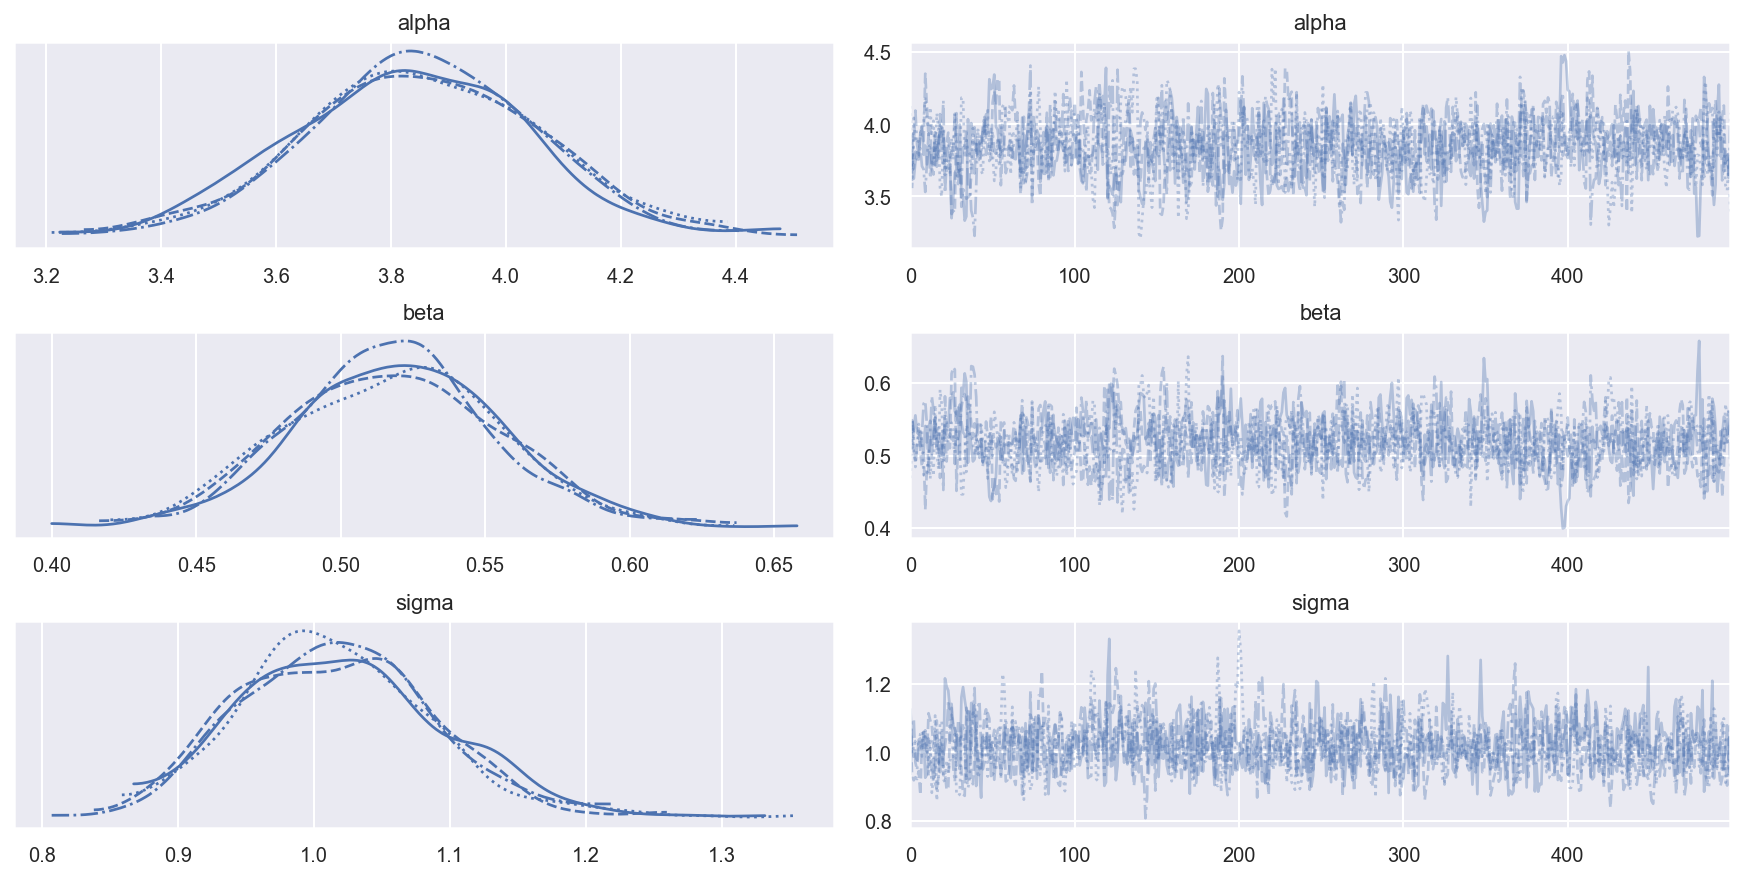

In [9]:
# inference_data = az.from_pystan(posterior=fit) # posterior kw is optional
az.plot_trace(fit, var_names=["alpha", "beta", "sigma"])
plt.show()

# Extra stuff

## Plot by hand

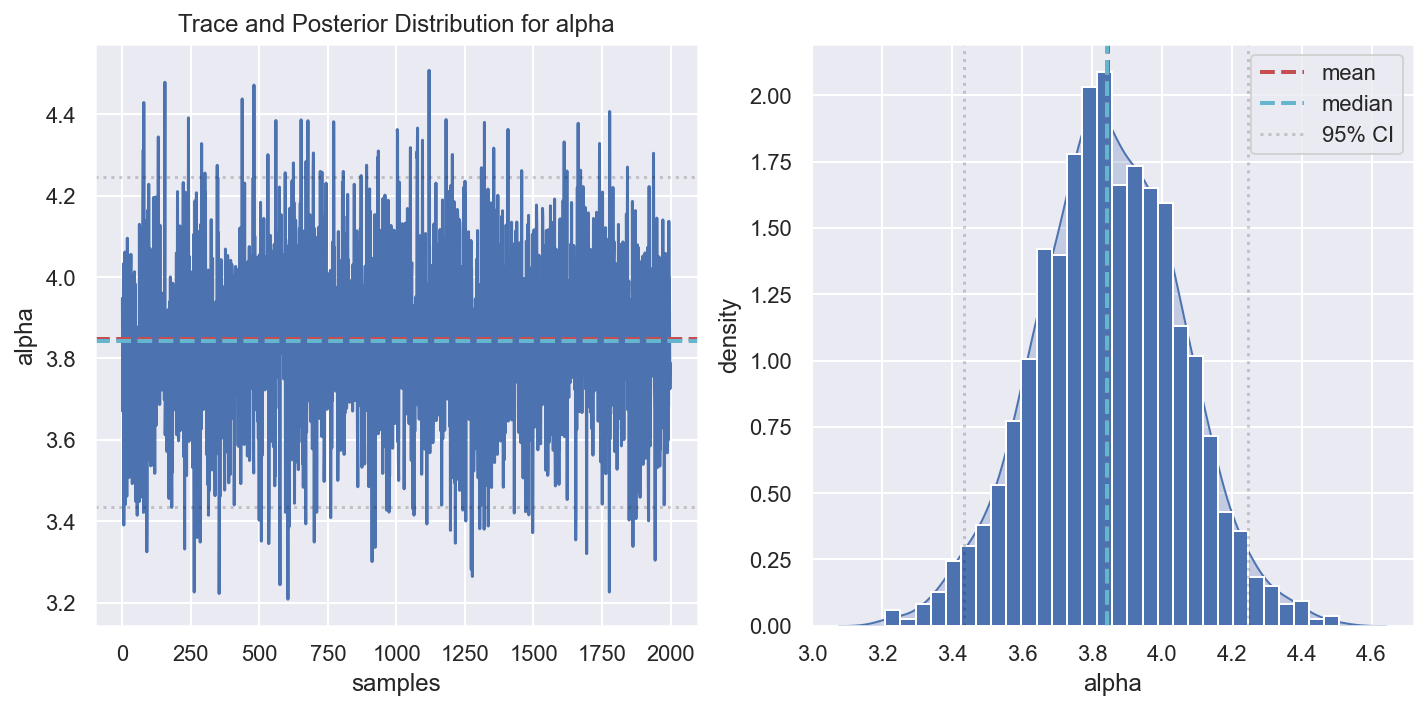

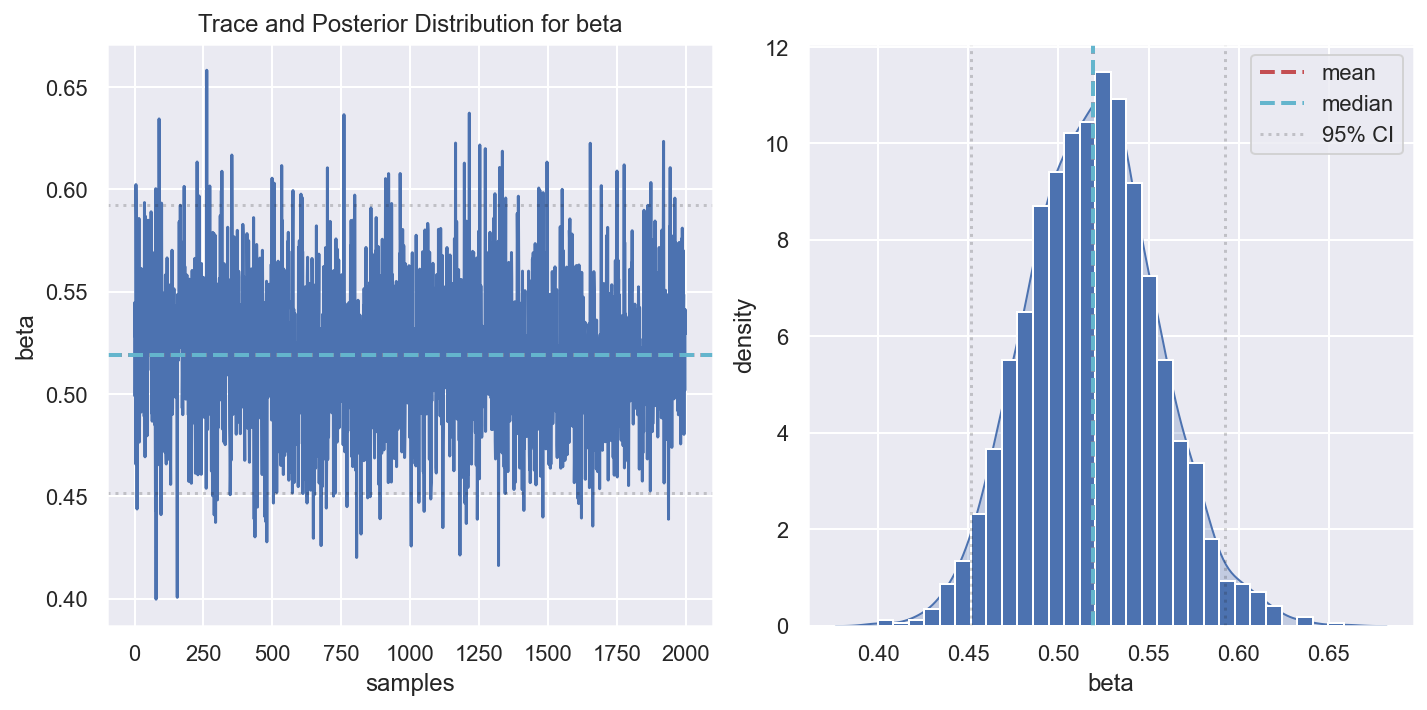

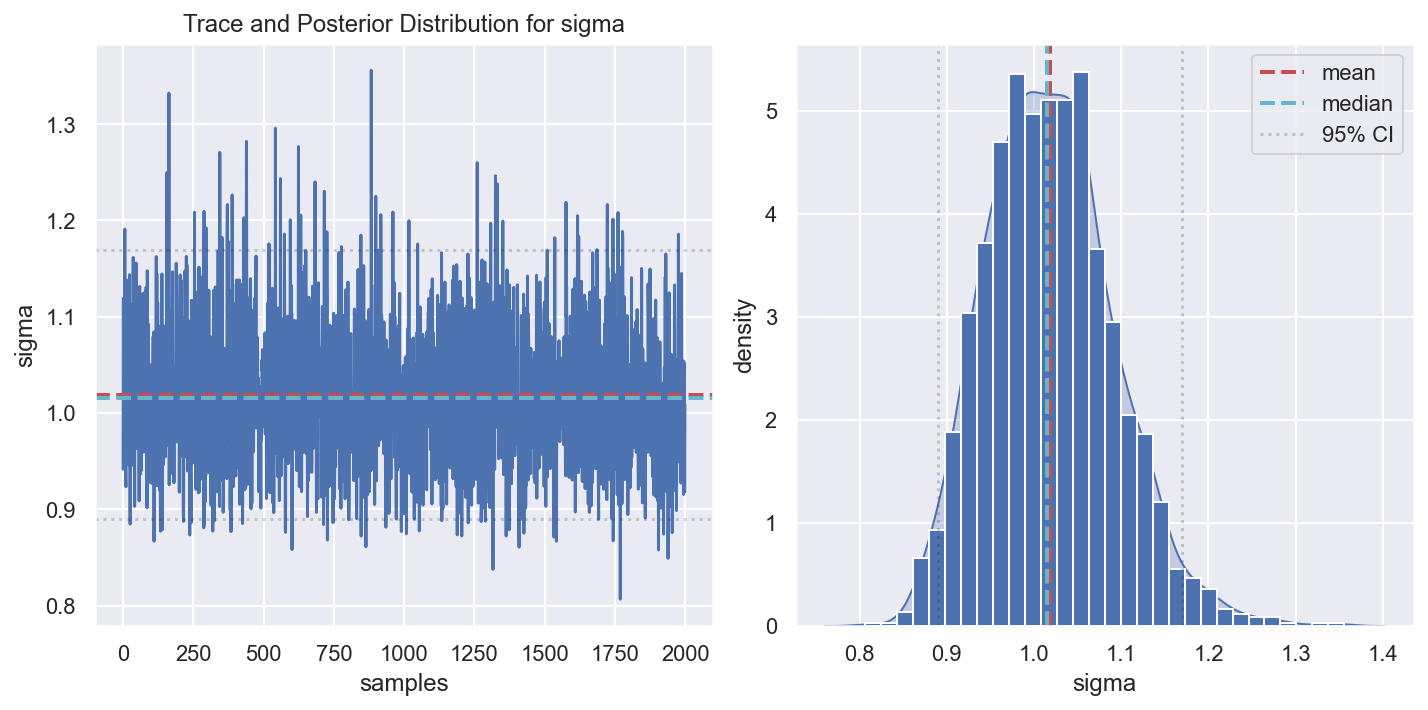

In [10]:
for param_name in ("alpha", "beta", "sigma"):

    # Extract trace
    param = fit[param_name]
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    
    ax = axes[0] 
    ax.plot(param)
    ax.set_xlabel('samples')
    ax.set_ylabel(param_name)
    ax.axhline(mean, color='r', lw=2, linestyle='--')
    ax.axhline(median, color='c', lw=2, linestyle='--')
    ax.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax.set_title('Trace and Posterior Distribution for {}'.format(param_name))

    ax = axes[1]
    ax.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax.legend()
    
    plt.tight_layout()

### Save the model

*Note: Set `force_compilation = False` to avoid the (quite long) compilation of the model if you didn't make any change since the last compilation*

In [8]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)
bkp_file = os.path.join(bkp_folder, 'model_theta.pkl')

if not os.path.exists(bkp_file) or force_compilation is True:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e4dbf306cdca355825a485cf99252251 NOW.


### Sampling

* `iter`: number of samples that will be generated from each Markov chain.
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is set to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. If thin is set to 1 (like here), every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.